# **CHAPTER 3. Metagenomes**

**Install conda env and activate it**

```
conda env create -f metagenomes.yaml
```

```
conda activate metagenomes
```

> Disclaimer: This part of the work was performed on a university server. Hybrid metagenomic assembly using SPAdes and functional profiling using HUMAnN3 requires a LOT of RAM.

## **Part 0. Install SPAdes v4.0.0 - the latest version**

In [ ]:
! wget https://github.com/ablab/spades/releases/download/v4.0.0/SPAdes-4.0.0-Linux.tar.gz

In [2]:
! tar -xzf SPAdes-4.0.0-Linux.tar.gz

In [3]:
! rm -rf SPAdes-4.0.0-Linux.tar.gz

## **Part 1. Hybrid metagenomic assembly**

`Assembly_pipeline` is a Snakemake pipeline that first conducts hybrid metagenomic assembly with `metaSPAdes` and then runs `MetaQuast` to assess the quality of the MAGs

In [ ]:
! snakemake -s Assembly_pipeline --cores all

As the result of this pipeline `MAGs` are stored in `MAGs_scaffolds` folder<br>
And `MetaQuast` reports are stored in `metaquast_reports`

After careful evaluation of MetaQuast reports, we decided to filter out sequences shorter than 3500 nucleotides from the MAGs

`Filtering_pipeline` is a Snakemake pipeline that runs our self-written python script `scripts/filter_MAGs.py` through each of 10 MAGs. Snakemake pipeline allowed to perform it quickly and step-by-step. Also it was convenient in terms of storing output files.

In [ ]:
! snakemake -s Filtering_pipeline --use-conda

As the result of this pipeline `filtered MAGs` are stored in `filtered_MAGs` folder<br>

## **Part 2. Functional profiling**

### **Part 2.1. Screening for antimicrobial resistance or virulence genes with `ABRicate`**

#### **Part 2.1.1. Force update `CARD`, `ResFinder` & `VFDB` databases**

Force update `CARD` database

In [ ]:
! abricate-get_db --db card --force

Force update `ResFinder` database

In [ ]:
! abricate-get_db --db resfinder --force

Force update `VFDB` database

In [ ]:
! abricate-get_db --db vfdb --force

#### **Part 2.1.2. Run `ABRicate`**

`ABRicate_pipeline` is a Snakemake pipeline that runs `ABRicate` against `CARD`, `ResFinder` & `VFDB` databases through all 10 filtered MAGs

In [ ]:
! snakemake -s ABRicate_pipeline --cores all --use-conda

As the result of this pipeline outputs are stored in `ABRicate_results` folder:
- `ABRicate_results/card`
- `ABRicate_results/resfinder`
- `ABRicate_results/vfdb`

#### **Part 2.1.3. Parse `ABRicate` outputs**

##### **Part 2.1.3.1. Creating directories to store files**

Create an `ABRicate_results/summary/` folder where merged results will be stored

In [8]:
! mkdir ABRicate_results/summary/

Create an `ABRicate_results/summary/txt` and `ABRicate_results/summary/tsv` folders where different file types of results will be stored

In [9]:
! mkdir ABRicate_results/summary/txt/
! mkdir ABRicate_results/summary/tsv/

##### **Part 2.1.3.2. Merging multiple outputs (per sample) into summary (per database)**

**`CARD` database**

Merge 10 different results on `CARD` database into one

In [ ]:
! abricate --summary ABRicate_results/card/*.txt > ABRicate_results/summary/txt/card_summary.txt

Convert it to `.tsv` file

`scripts/abr2tsv.py` does:
- Converts `.txt` file to `.tsv`
- Renames column `#FILE` to `SAMPLE`
- Renames sample name from `ABRicate_results/{db}/{sample}_{db}.txt` to `{sample}`

In [19]:
# Usage
# {path_to_script} {path_to_input_txt_file} {path_to_output_tsv_file}
%run scripts/abr2tsv.py 'ABRicate_results/summary/txt/card_summary.txt' 'ABRicate_results/summary/tsv/card_summary.tsv'

Modified file saved to: ABRicate_results/summary/tsv/card_summary.tsv


**`ResFinder` database**

Merge 10 different results on `ResFinder` database into one

In [ ]:
! abricate --summary ABRicate_results/resfinder/*.txt > ABRicate_results/summary/txt/resfinder_summary.txt

Convert it to `.tsv` file

In [17]:
# Usage
# {path_to_script} {path_to_input_txt_file} {path_to_output_tsv_file}
%run scripts/abr2tsv.py 'ABRicate_results/summary/txt/resfinder_summary.txt' 'ABRicate_results/summary/tsv/resfinder_summary.tsv'

Modified file saved to: ABRicate_results/summary/tsv/resfinder_summary.tsv


**`VFDB` database**

Merge 10 different results on `VFDB` database into one

In [ ]:
! abricate --summary ABRicate_results/vfdb/*.txt > ABRicate_results/summary/txt/vfdb_summary.txt

Convert it to `.tsv` file

In [18]:
# Usage
# {path_to_script} {path_to_input_txt_file} {path_to_output_tsv_file}
%run scripts/abr2tsv.py 'ABRicate_results/summary/txt/vfdb_summary.txt' 'ABRicate_results/summary/tsv/vfdb_summary.tsv'

Modified file saved to: ABRicate_results/summary/tsv/vfdb_summary.tsv


##### **Part 2.1.3.3. Convert `ABRicate` summary output format into `presence` format**

`ABRicate` summary output is a simple matrix of gene presence/absence. An absent gene is denoted `.` and a present gene is represented by its `%COVERAGE`.<br>
Yet while dealing with MAGs there could be more than 1 occurence of some gene. In that case ABRicate writes `100.00;100.00;99.94;100.00;100.00` into its cell.<br>
However we are still interested in presence/abscence of genes. That is why we wrote `scripts/abr_tsv2presence.py` script that will change `.` into `minus` and whatever else into `plus` for the sake of convenience in further visualization.

Create an `ABRicate_results/summary/presence/` folder where files will be stored

In [13]:
! mkdir ABRicate_results/summary/presence

**Convert `_summary.tsv` to `_presence.tsv` - `CARD` database**

In [14]:
# Usage
# {path_to_script} {path_to_input_summary_file} {path_to_output_presence_file}
%run scripts/abr_tsv2presence.py 'ABRicate_results/summary/tsv/card_summary.tsv' 'ABRicate_results/summary/presence/card_presence.tsv'

Modified file saved to: ABRicate_results/summary/presence/card_presence.tsv


**Convert `_summary.tsv` to `_presence.tsv` - `ResFinder` database**

In [15]:
# Usage
# {path_to_script} {path_to_input_summary_file} {path_to_output_presence_file}
%run scripts/abr_tsv2presence.py 'ABRicate_results/summary/tsv/resfinder_summary.tsv' 'ABRicate_results/summary/presence/resfinder_presence.tsv'

Modified file saved to: ABRicate_results/summary/presence/resfinder_presence.tsv


**Convert `_summary.tsv` to `_presence.tsv` - `VFDB` database**

In [16]:
# Usage
# {path_to_script} {path_to_input_summary_file} {path_to_output_presence_file}
%run scripts/abr_tsv2presence.py 'ABRicate_results/summary/tsv/vfdb_summary.tsv' 'ABRicate_results/summary/presence/vfdb_presence.tsv'

Modified file saved to: ABRicate_results/summary/presence/vfdb_presence.tsv


#### **Part 2.1.4. Visualization**

Please open `RStudio` and go through  `ABRicate_heatmaps_journal.R` script.<br>
There are a lot of manual adjustments to the plots to make it executable.

#### **Part 2.1.5. Create a merged summary**

Create a `merged_summary.tsv` file with the number of genes founds per sample in each of three databases

In [2]:
import pandas as pd

In [18]:
# Load only the SAMPLE and NUM_FOUND columns from each dataset
card_df = pd.read_csv('ABRicate_results/summary/tsv/card_summary.tsv', sep='\t', usecols=['SAMPLE', 'NUM_FOUND'])
resfinder_df = pd.read_csv('ABRicate_results/summary/tsv/resfinder_summary.tsv', sep='\t', usecols=['SAMPLE', 'NUM_FOUND'])
vfdb_df = pd.read_csv('ABRicate_results/summary/tsv/vfdb_summary.tsv', sep='\t', usecols=['SAMPLE', 'NUM_FOUND'])

# Rename the NUM_FOUND columns to distinguish them
card_df.rename(columns={'NUM_FOUND': 'card'}, inplace=True)
resfinder_df.rename(columns={'NUM_FOUND': 'resfinder'}, inplace=True)
vfdb_df.rename(columns={'NUM_FOUND': 'vfdb'}, inplace=True)

# Merge the datasets on the SAMPLE column
merged_df = card_df.merge(resfinder_df, on='SAMPLE').merge(vfdb_df, on='SAMPLE')

# Save the merged dataset to a new TSV file
merged_df.to_csv('ABRicate_results/summary/tsv/merged_summary.tsv', sep='\t', index=False)

##### **Part 2.1.5.1. Visualization**

Please open `RStudio` and go through  `ABRicate_barplots_journal.R` script.<br>
There are a lot of manual adjustments to the plots to make it executable.

### **Part 2.2. Profiling microbial pathways with `HUMAnN3`**

>Disclaimer: it is important to install `HUMAnN3` properly with all the requirements and dependecies. <br>
> Although `HUMAnN3` will be installed with `metagenomes.yaml` conda envinronment it is also important to install all the databases needed. Please follow the official [installation guide](https://github.com/biobakery/humann?tab=readme-ov-file#initial-installation)<br>
> In the `metagenomes.yaml` `HUMAnN3` is already installed with `pip` so proceed to:
> - **Download the ChocoPhlAn database:**
> ```
> humann_databases --download chocophlan full $INSTALL_LOCATION
> ```
> - **Download a translated search database:**
> ```
> humann_databases --download uniref uniref90_diamond $INSTALL_LOCATION
> ```

#### **Part 2.2.1. Run `HUMAnN3`**

>Disclaimer: `HUMAnN3` could be run in `--bypass-prescreen` mode<br>
>In this mode it bypasses the taxomonic profiling with `MetaPhlAn` step<br>
>Yet we wanted to compare taxonomic identification with `MetaPhlAn` and `Kraken2`<br>

`HUMAnN3_pipeline` is a Snakemake pipeline that runs `HUMAnN3` through all 10 filtered MAGs

In [ ]:
! snakemake -s HUMAnN3_pipeline --cores all --use-conda

As the result of this pipeline outputs are stored in `HUMAnN3_results/by_samples` folder:

#### **Part 2.2.2. Parse results**

##### **Part 2.2.2.1. Path abundance files**

Create `HUMAnN3_results/pathabundance_tables` folder to store all `pathabundance.tsv` files

In [1]:
! mkdir HUMAnN3_results/pathabundance_tables

Copy `HUMAnN3_results/by_samples/{sample}/{sample}_pathabundance.tsv` files to the `HUMAnN3_results/pathabundance_tables` folder

In [2]:
! cp HUMAnN3_results/by_samples/*/*_pathabundance.tsv HUMAnN3_results/pathabundance_tables/

Merge all `pathabundance.tsv` files

In [ ]:
! humann_join_tables --input HUMAnN3_results/pathabundance_tables/ --output HUMAnN3_results/HUMAnN3_merged_pathabundance.tsv

Filter `HUMAnN3_results/HUMAnN3_merged_pathabundance.tsv` file

`scripts/filt_humann3.py` does:
- Deletes every row that contains `UNMAPPED`, `UNINTEGRATED`, `unclassified` (`MetaPhlAn` did not handle taxonomic profiling at all)
- Renames column `# Pathway` to `Pathway`
- Renames sample name from `{sample}_Abundance` to `{sample}`

In [20]:
# Usage
# {path_to_script} {path_to_input_file} {path_to_output_file}
%run scripts/filt_humann3.py 'HUMAnN3_results/HUMAnN3_merged_pathabundance.tsv' 'HUMAnN3_results/pathabundance_filtered.tsv'

Modified file saved to: HUMAnN3_results/pathabundance_filtered.tsv


Normalize to relative abundance with  `total sum scaling (TSS)`-style normalization

In [1]:
! humann_renorm_table --input HUMAnN3_results/pathabundance_filtered.tsv --units relab --output HUMAnN3_results/pathabundance_filtered_normalized.tsv

Loading table from: HUMAnN3_results/pathabundance_filtered.tsv


##### **Part 2.2.2.2. Gene families files**

Create `HUMAnN3_results/genefamilies_tables` folder to store all `genefamilies.tsv` files

In [3]:
! mkdir HUMAnN3_results/genefamilies_tables

Copy `HUMAnN3_results/by_samples/{sample}/{sample}_genefamilies.tsv` files to the `HUMAnN3_results/genefamilies_tables/` folder

In [4]:
! cp HUMAnN3_results/by_samples/*/*_genefamilies.tsv HUMAnN3_results/genefamilies_tables/

Merge all `genefamilies.tsv` files

In [ ]:
! humann_join_tables --input HUMAnN3_results/genefamilies_tables/ --output HUMAnN3_results/HUMAnN3_merged_genefamilies.tsv

Filter `HUMAnN3_results/HUMAnN3_merged_genefamilies.tsv` file

`scripts/filt_humann3.py` does:
- Deletes every row that contains `UNMAPPED`, `UNINTEGRATED`, `unclassified` (`MetaPhlAn` did not handle taxonomic profiling at all)
- Renames column `# Gene Family` to `Gene_Family`
- Renames sample name from `{sample}-RPKs` to `{sample}`

In [21]:
# Usage
# {path_to_script} {path_to_input_file} {path_to_output_file}
%run scripts/filt_humann3.py 'HUMAnN3_results/HUMAnN3_merged_genefamilies.tsv' 'HUMAnN3_results/genefamilies_filtered.tsv'

Modified file saved to: HUMAnN3_results/genefamilies_filtered.tsv


Normalize to relative abundance with  `total sum scaling (TSS)`-style normalization

In [1]:
! humann_renorm_table --input HUMAnN3_results/genefamilies_filtered.tsv --units relab --output HUMAnN3_results/genefamilies_filtered_normalized.tsv

Loading table from: HUMAnN3_results/genefamilies_filtered.tsv


#### **Part 2.2.3. Comparative statistics**

Copy metadata from `02_Diff_analysis`<br>
It was created during **`Part 1.4. Create metadata`** step

In [ ]:
! cp ../02_Diff_analysis/metadata.csv ./

##### **Part 2.2.3.1. Differential Pathway Abundance**

Transpose `HUMAnN3_results/pathabundance_filtered_normalized.tsv` and convert it to `.csv` for better input to `MaAsLin2`

In [1]:
# Usage
# {path_to_script} {path_to_input_file} {path_to_output_file}
%run scripts/transpose_humann.py 'HUMAnN3_results/pathabundance_filtered_normalized.tsv' 'HUMAnN3_results/pathabundance_transposed.csv'

Transposed file saved to: HUMAnN3_results/pathabundance_transposed.csv


Run `MaAsLin2`

>Please notice: this `scripts/MaAsLin2.R` differs from `scripts/MaAsLin2.R` script in `02_Diff_analysis`. This version of the script uses `normalization  = "NONE"` as there is no need to normalize the data.

In [ ]:
%%bash
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
Rscript scripts/MaAsLin2.R metadata.csv HUMAnN3_results/pathabundance_transposed.csv MaAsLin2_on_HUMAnN3_results

In [4]:
MaAsLin2_on_HUMAnN3_results = pd.read_csv('MaAsLin2_on_HUMAnN3_results/significant_results.tsv', sep='\t')
MaAsLin2_on_HUMAnN3_results

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval


#### **Part 2.2.4. Visualization**

We will visualize only `HUMAnN3_results/pathabundance_filtered_normalized.tsv` file because:
- UniRef90 database found more than 10K gene families! It is impossible to visualize.
- `MaAsLin2` did not found any significant results in differential pathway abundance. Volcano plot cannot be implemented in this case because it makes no sense in terms of pathways. According to the official [`bioBakery` guideline](https://github.com/biobakery/biobakery/wiki/humann3#5-plotting-stratified-functions), if `MaAsLin2` finds something in `HUMAnN3` pathabund output it must be visualized as `humann_barplot`. Yet we have nothing to visualize.

Please open `RStudio` and go through  `HUMAnN3_heatmaps_journal.R` script.<br>
There are a lot of manual adjustments to the plots to make it executable.

### **Part 2.3. `KEGG` pathways completeness with `eggNOG-mapper` and `KEGGaNOG`**

`emapKEGG_pipeline` is a Snakemake pipeline that runs `eggNOG-mapper` & `KEGGaNOG` through all 10 filtered MAGs

In [ ]:
! snakemake -s emapper_pipeline --use-conda

As the result of this pipeline outputs are stored in `eggNOG` folder:
- `{sample}`:
    - `{prefix}.emapper.annotations`
    - `{prefix}.emapper.genepred.fasta`
    - `{prefix}.emapper.genepred.gff`
    - `{prefix}.emapper.hits`
    - `{prefix}.emapper.seed_orthologs`

We are interested in the heatmap of `KEGG` pathways completenesses. For this we need a `.txt` file with file locations of `{prefix}.emapper.annotations` files. Let's create it.

In [1]:
import os

In [3]:
# Define the directory and file path
directory = "eggNOG"
file_path = os.path.join(directory, "annotations.txt")

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Define the content to write to the file
content = """\
eggNOG/D1/VM1.emapper.annotations
eggNOG/D2/VM2.emapper.annotations
eggNOG/D3/VM3.emapper.annotations
eggNOG/D5/VM5.emapper.annotations
eggNOG/P1/NN1.emapper.annotations
eggNOG/P2/NN2.emapper.annotations
eggNOG/P3/NN3.emapper.annotations
eggNOG/P4/NN4.emapper.annotations
eggNOG/P5/NN5.emapper.annotations
"""

# Write the content to the file
with open(file_path, "w") as f:
    f.write(content)

print(f"'annotations.txt' has been created in the '{directory}' directory.")

'annotations.txt' has been created in the 'eggNOG' directory.


Now everything is ready for launching `KEGGaNOG`.<br>

In [ ]:
! KEGGaNOG --multi -i eggNOG/annotations.txt -o KEGGaNOG -dpi 600 -g

Great! But if we take a look at default `KEGGaNOG` visualization there is a mess in order of samples! Let's fix it!

Read `KEGGaNOG` output

In [ ]:
kegganog_df = pd.read_csv("KEGGaNOG/merged_pathways.tsv", sep="\t")

Let's take a loot at it

In [4]:
kegganog_df.head(2)

,Function,NN3,NN4,NN5,NN2,VM2,VM5,VM3,NN1,VM1
0,3-Hydroxypropionate Bicycle,0.24,0.29,0.24,0.29,0.24,0.24,0.24,0.24,0.24
1,4-Hydroxybutyrate/3-hydroxypropionate,0.20,0.20,0.20,0.20,0.40,0.20,0.20,0.20,0.20


Ahh... The order of samples is messed up... We fix it!

In [8]:
kegganog_df_reord = kegganog_df[['Function', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'VM1', 'VM2', 'VM3', 'VM5']]
kegganog_df_reord.head(2)

,Function,NN1,NN2,NN3,NN4,NN5,VM1,VM2,VM3,VM5
0,3-Hydroxypropionate Bicycle,0.24,0.29,0.24,0.29,0.24,0.24,0.24,0.24,0.24
1,4-Hydroxybutyrate/3-hydroxypropionate,0.20,0.20,0.20,0.20,0.20,0.20,0.40,0.20,0.20


Now we are ready to go!

In [5]:
from kegganog import grouped_heatmap_multi

Preparing heatmap data:   0%|          | 0/6 [00:00<?, ?it/s]/Volumes/SAMSUNG_SSD/Documents/miniconda3/conda_envs/kegganog/lib/python3.12/site-packages/kegganog/grouped_heatmap_multi.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_decoder_file["Group"] = kegg_decoder_file["Function"].apply(
Creating heatmap parts: 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]
/Volumes/SAMSUNG_SSD/Documents/miniconda3/conda_envs/kegganog/lib/python3.12/site-packages/kegganog/grouped_heatmap_multi.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
Saving plot: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


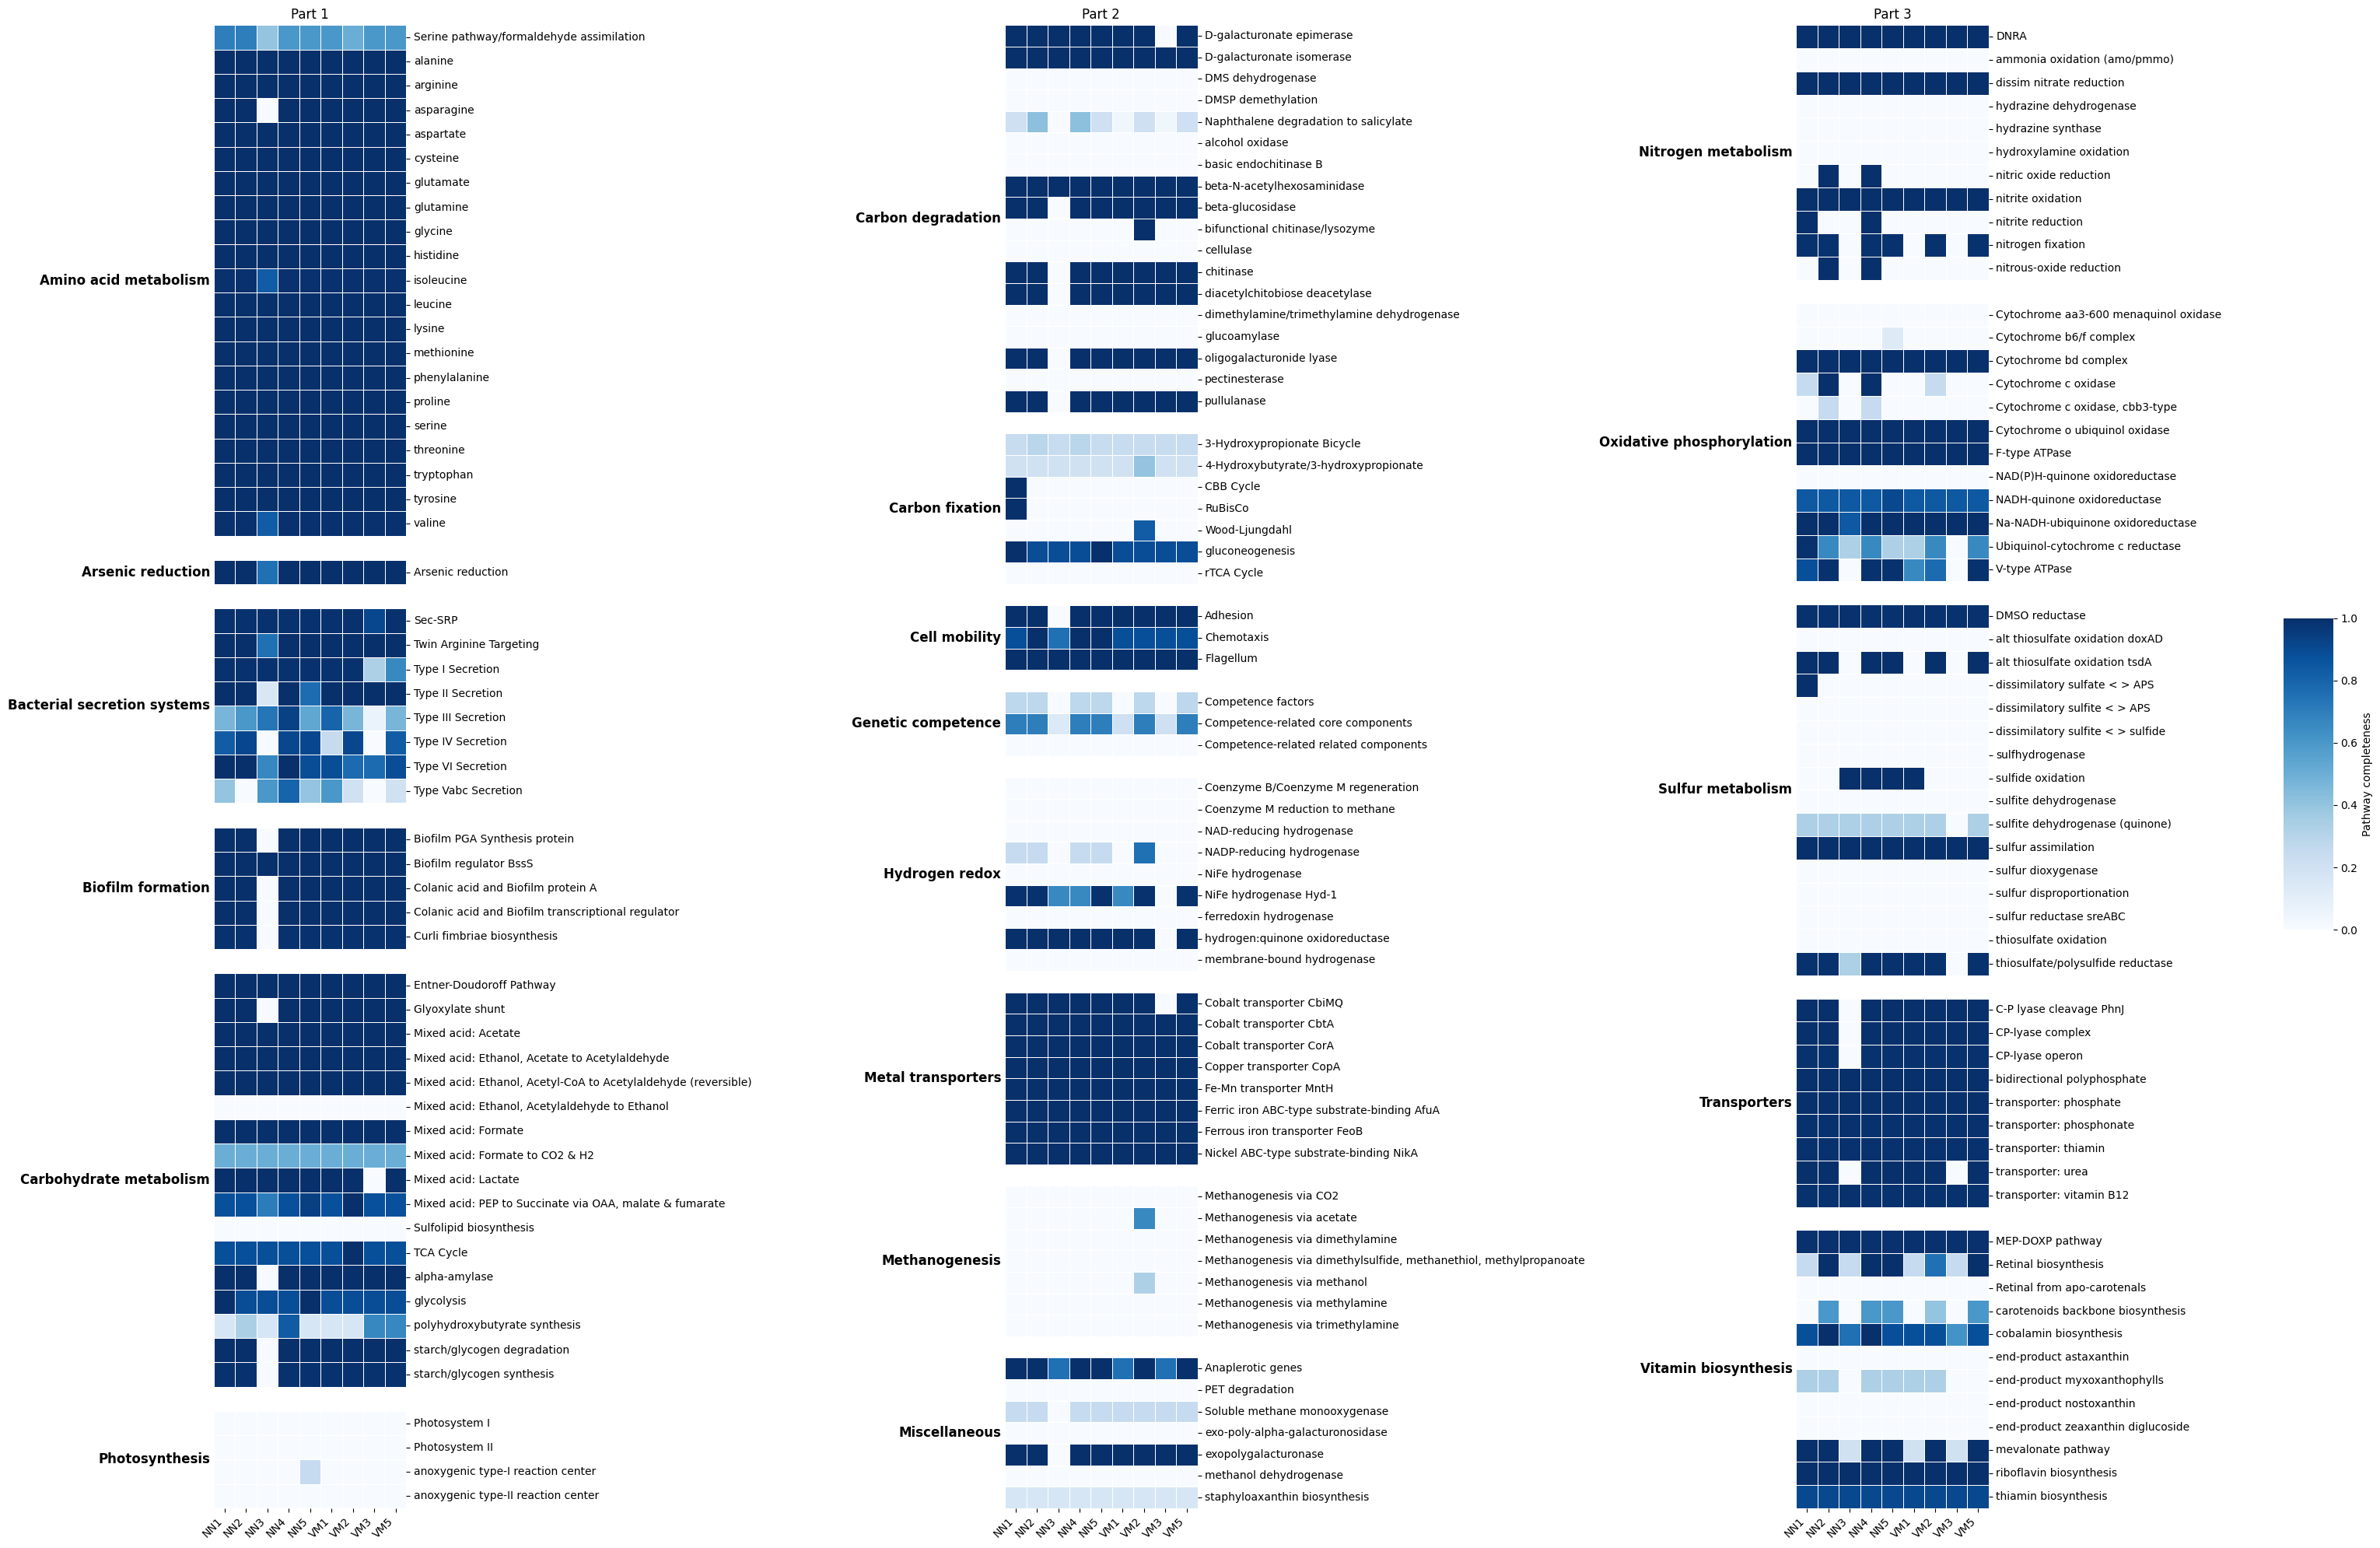

In [9]:
grouped_heatmap_multi.generate_grouped_heatmap_multi(kegganog_df_reord, "images", 600, "Blues")

Rename the plot file

In [10]:
! mv images/heatmap_figure.png images/KEGGaNOG_heatmap.png

And we want a correlation network plot!

In [11]:
from kegganog import correlation_network

Correlation network saved as images/KEGGaNOG_corrnet.png


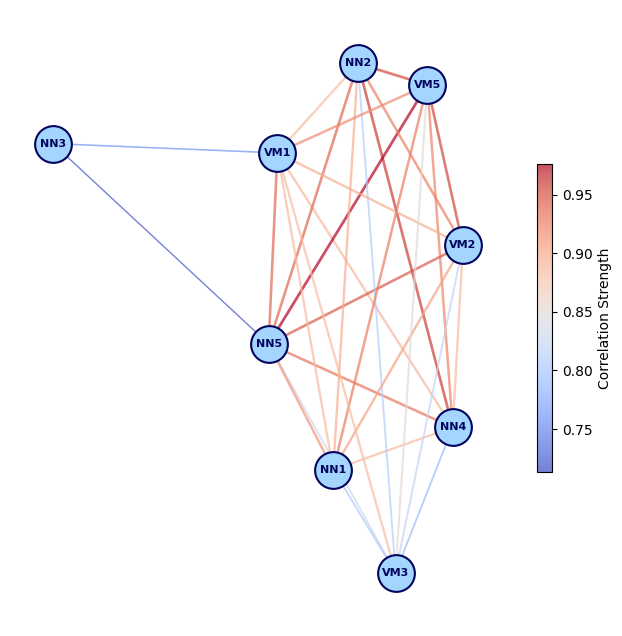

In [24]:
correlation_network(
    kegganog_df,
    figsize = (8, 8),
    threshold = 0.7,
    node_color = "#A3D5FF",
    node_edgecolors = "#03045E",
    node_linewidths = 1.5,
    label_font_size = 8,
    label_font_color = "#03045E",
    label_verticalalignment = "center",
    label_horizontalalignment = "center",
    label_font_weight = "bold",
    cbar_size = 0.5,
    title = None,
    background_color = "white",
    save_path = "images/KEGGaNOG_corrnet.png",
    save_format = "png",
    save_dpi = 600
)